# Motivation
Fraudulent Transactions incur heavy, and sometimes unrecoverable, financial damage to credit card users. Detection of such transactions can help prevent financial loss of the victims and reduce financial crimes. Through the power of machine learning, it is possible to make use of the large amount of data available in order to detect such transactions.

# Data
Here, I made use of publicly available data for the detection of fraudulent transactions. The dataset used for this project is a .csv file and is publicly available on Kaggle at this link: 
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

This dataset has 284,807 transactions, consists of 30 features, and has a binary label: whether a transaction is fraudulent or not. All but two of the features in this dataset are the result of PCA (Principal Component Analysis). The two features are “time” and “amount” of the transactions. All the features that result from PCA are anonymized in order to prevent any possibility of tracing the financial data back to a client, thus, no information is available on what they present or mean. Regardless of the situation, I proceed to carry out the classification with the available information.

The transaction data is mostly clean and does not have major inconsistencies. Only few records have missing data, and since we have a large number of records, we can just discard those transactions and make use of the rest of the data.

It is worth noting that the data is highly skewed, since most of the transactions that occur are legitimate and only a tiny portion of them are fraudulent. This results in our dataset having 99.83% of its records in class 0 (legtimate transaction) and 0.17% of it in class 1 (fraudulent transaction).

# Method of Approach
The subtasks for this project are carried out in the order given below:
1. Prepare and process the data
1. Analyze the data
1. Model and Compare
1. Train and Test

Extra information about each step is given in their respective sections.

# Prepare and Process
Below, the data is loaded and preprocessed to have it ready for use.
### Importing libraries

In [1]:
import keras
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay, auc, roc_curve, confusion_matrix, ConfusionMatrixDisplay

### Loading Data

In [2]:
dataset = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv").dropna()

# loading data, splitting it
x = dataset.iloc[:, dataset.columns != "Class"]
y = dataset["Class"]
record_count, feature_count = x.shape

xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=42)
print("Set sizes:", xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)
print("Fraudulent transactions: Training =", np.sum(ytrain), "Testing =", np.sum(ytest))

scaler = MinMaxScaler()

Set sizes: (213605, 30) (71202, 30) (213605,) (71202,)

Fraudulent transactions: Training = 379 Testing = 113


# Analyze
Here, we take a closer look at the data. Since we do not know what each feature represents, it is not possible to understand much from plotting features against one another. As a result, we take a look at the histograms of the features and their box plots. The visualizations for the features are carried out in Tableau and can be found in the link below.
https://public.tableau.com/app/profile/pedram.abdolahi.darestani/viz/CFD_17043368259820/V1

Furthermore, the correlation matrix of the features is shown below.
### Correlation matrix

<Figure size 2000x2000 with 0 Axes>

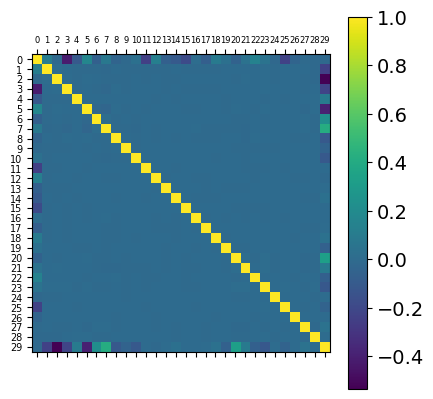

In [8]:
# Feature correlation matrix
plt.figure(figsize=(20, 20))
plt.matshow(xtrain.corr())
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.xticks(range(30), fontsize=6)
plt.yticks(range(30), fontsize=7)
plt.savefig("output.png")
plt.show()

The takeaways from the visualizations can be summarized as such:
- Many of the variables show a similar distribution to the normal distribution.
- There were multiple instances in which the quartiles were too far from the points available in the dataset. These points are not outliers, but show that most of the records exist within a specific range.
- The Time variable shows the time of the transaction, so it is understandable why it presents the histogram it does.
- The correlation matrix shows that the features which are the result of PCA, have minimal correlation with eachother. This indicates a successful PCA.
- Feature 0 and feature 30 in the correlation plot are Time and Amount, respectively. These features are not a result of PCA and show non-zero amount of correlation with other variables.
- In order to map the available features to the target variable, modeling of the data is required.

# Model and Compare
The task that we have at hand is a binary classification problem: a transaction is either fraudulent with the class value of 1, or legitimate with the class value of 0. Here, I train models from simple to more complex ones. These are, in the order of complexity: 
1. linear classification models
1. tree models
1. neural networks

### Data evaluation method
For all but the neural models, 25% of the total data is sampled randomly in a stratified manner and the rest is used for validation and training. This results in having roughly 25% of the positive class in the test set as well. As for the neural models, since k-fold cross validation is not ideal for validation of these models, 20% of the *training set* was randomly sampled to act as the validation data (straified sampling).

I make use of precision, recall, and f1-score in order to evaluate and compare the models. 
* Precision: the ratio of correct classifications of our model to all of its predictions.
* Recall: the ratio of the positive classes that the model detects.
* F1-score: it can be seen as an average of precision and recall. 

Model selection is carried out with validation scores of the said measures.
### Ridge classification

In [9]:
ridge = RidgeClassifier()

scores = cross_validate(ridge, xtrain, ytrain, scoring=['precision', 'recall', 'f1'], n_jobs=-1)
print("Cross validation precision: mean={0}, std={1}".format(np.mean(scores['test_precision']), np.std(scores['test_precision'])))
print("Cross validation recall: mean={0}, std={1}".format(np.mean(scores['test_recall']), np.std(scores['test_recall'])))
print("Cross validation f1 score: mean={0}, std={1}".format(np.mean(scores['test_f1']), np.std(scores['test_f1'])))  

Cross validation precision: mean=0.8535970935970937, std=0.038691701625496566

Cross validation recall: mean=0.4144210526315789, std=0.060526407322585254

Cross validation f1 score: mean=0.5555601286893067, std=0.057974753946502235


### Logistic Regression

In [10]:
lRegression = LogisticRegression(max_iter=10000, n_jobs=-1)

scores = cross_validate(lRegression, xtrain, ytrain, scoring=['precision', 'recall', 'f1'], n_jobs=-1)
print("Cross validation precision: mean={0}, std={1}".format(np.mean(scores['test_precision']), np.std(scores['test_precision'])))
print("Cross validation recall: mean={0}, std={1}".format(np.mean(scores['test_recall']), np.std(scores['test_recall'])))
print("Cross validation f1 score: mean={0}, std={1}".format(np.mean(scores['test_f1']), np.std(scores['test_f1'])))  

Cross validation precision: mean=0.8681090949214088, std=0.04931222450666773

Cross validation recall: mean=0.6492631578947369, std=0.05066275438071289

Cross validation f1 score: mean=0.7417216433528256, std=0.0427454773570193


### SVM

In [11]:
svmodel = SVC(kernel="linear")

scores = cross_validate(svmodel, xtrain, ytrain, scoring=['precision', 'recall', 'f1'], n_jobs=-1)
print("Cross validation precision: mean={0}, std={1}".format(np.mean(scores['test_precision']), np.std(scores['test_precision'])))
print("Cross validation recall: mean={0}, std={1}".format(np.mean(scores['test_recall']), np.std(scores['test_recall'])))
print("Cross validation f1 score: mean={0}, std={1}".format(np.mean(scores['test_f1']), np.std(scores['test_f1'])))  

Cross validation precision: mean=0.688050807027998, std=0.1023304590131568

Cross validation recall: mean=0.35375438596491227, std=0.05242821529778176

Cross validation f1 score: mean=0.4653367928077268, std=0.06472021716207338


### Decision Tree

In [12]:
dtmodel = DecisionTreeClassifier(min_samples_split=3)

scores = cross_validate(dtmodel, xtrain, ytrain, scoring=['precision', 'recall', 'f1'], n_jobs=-1)
print("Cross validation precision: mean={0}, std={1}".format(np.mean(scores['test_precision']), np.std(scores['test_precision'])))
print("Cross validation recall: mean={0}, std={1}".format(np.mean(scores['test_recall']), np.std(scores['test_recall'])))
print("Cross validation f1 score: mean={0}, std={1}".format(np.mean(scores['test_f1']), np.std(scores['test_f1'])))  

Cross validation precision: mean=0.7402803274181676, std=0.03806486954803024

Cross validation recall: mean=0.773298245614035, std=0.07085707548437793

Cross validation f1 score: mean=0.7531759574230412, std=0.02714725616159582


### Random forest

In [3]:
rfmodel = RandomForestClassifier(n_jobs=-1, n_estimators=200)

scores = cross_validate(rfmodel, xtrain, ytrain, scoring=['precision', 'recall', 'f1'], n_jobs=-1)
print("Cross validation precision: mean={0}, std={1}".format(np.mean(scores['test_precision']), np.std(scores['test_precision'])))
print("Cross validation recall: mean={0}, std={1}".format(np.mean(scores['test_recall']), np.std(scores['test_recall'])))
print("Cross validation f1 score: mean={0}, std={1}".format(np.mean(scores['test_f1']), np.std(scores['test_f1'])))

Cross validation precision: mean=0.9496726423481643, std=0.018445767257217846

Cross validation recall: mean=0.7757543859649123, std=0.041446216451085

Cross validation f1 score: mean=0.8528449741194342, std=0.018640840626011956


### Tree Ensemble

In [4]:
bagmodel = BaggingClassifier(n_jobs=-1, n_estimators=200)

scores = cross_validate(bagmodel, xtrain, ytrain, scoring=['precision', 'recall', 'f1'], n_jobs=-1)
print("Cross validation precision: mean={0}, std={1}".format(np.mean(scores['test_precision']), np.std(scores['test_precision'])))
print("Cross validation recall: mean={0}, std={1}".format(np.mean(scores['test_recall']), np.std(scores['test_recall'])))
print("Cross validation f1 score: mean={0}, std={1}".format(np.mean(scores['test_f1']), np.std(scores['test_f1'])))

Cross validation precision: mean=0.9277957403579936, std=0.02522525462766752

Cross validation recall: mean=0.7916491228070176, std=0.0462789061008606

Cross validation f1 score: mean=0.8528715153051196, std=0.019341894026488546


### MLP
For the MLP (Multi Layered Perceptron) model, Tensorflow and Keras libraries are used.
Sparse search was carried out for finding a local optimum for the model hyper parameters. The specifications of the best model found are given below.
- Hidden layer count: 12
- Neurons in each layer: 128, 32x10, 8, 2, 1
- Hidden layer activation function: ReLU
- Output layer activation function: Sigmoid
- Loss function: Binary crossentropy
- Optimizer: ADAM

In [10]:
tfMlp = Sequential()
tfMlp.add(Dense(128, activation='relu', input_shape=(xtrain.shape[1],)))
tfMlp.add(Dense(32, activation='relu'))
tfMlp.add(Dense(32, activation='relu'))
tfMlp.add(Dense(32, activation='relu'))
tfMlp.add(Dense(32, activation='relu'))
tfMlp.add(Dense(32, activation='relu'))
tfMlp.add(Dense(32, activation='relu'))
tfMlp.add(Dense(32, activation='relu'))
tfMlp.add(Dense(32, activation='relu'))
tfMlp.add(Dense(32, activation='relu'))
tfMlp.add(Dense(32, activation='relu'))
tfMlp.add(Dense(8, activation='relu'))
tfMlp.add(Dense(2, activation='relu'))
tfMlp.add(Dense(1, activation='sigmoid'))
tfMlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.metrics.Precision(), tf.metrics.Recall()])

xx, xval, yy, yval = train_test_split(xtrain, ytrain, test_size=0.2)
xx = scaler.fit_transform(xx)

# earlyStopping = EarlyStopping(monitor='val_loss', mode='min', patience=1000, restore_best_weights=True)
earlyStopping = EarlyStopping(monitor='val_loss', mode='min', patience=1000, restore_best_weights=False)
tfMlp.fit(xx, yy, epochs=100, validation_data=(xval, yval), callbacks=[earlyStopping], verbose=0)
tfMlp.save("tfMLP.h5")
joblib.dump(scaler, 'tfScaler.sav')

preds = np.asarray(np.round(tfMlp.predict(xx)), dtype=int)
print("Training Accuracy: {}".format(accuracy_score(yy, preds)))
print("Training Precision: {}".format(precision_score(yy, preds)))
print("Training Recall: {}".format(recall_score(yy, preds)))
print("Training F1 Score: {}".format(f1_score(yy, preds)))
print("=="*42)


preds = np.asarray(np.round(tfMlp.predict(scaler.transform(xval))), dtype=int)
print("Validation Accuracy: {}".format(accuracy_score(yval, preds)))
print("Validation Precision: {}".format(precision_score(yval, preds)))
print("Validation Recall: {}".format(recall_score(yval, preds)))
print("Validation F1 Score: {}".format(f1_score(yval, preds)))


5341/5341 [==============================] - 6s 1ms/step

Training Accuracy: 0.9994440673205215

Training Precision: 0.8727272727272727

Training Recall: 0.8

Training F1 Score: 0.8347826086956521


1336/1336 [==============================] - 1s 1ms/step

Validation Accuracy: 0.9993679923222771

Validation Precision: 0.8421052631578947

Validation Recall: 0.810126582278481

Validation F1 Score: 0.8258064516129032


### MLP ROC Curve

2226/2226 [==============================] - 2s 997us/step


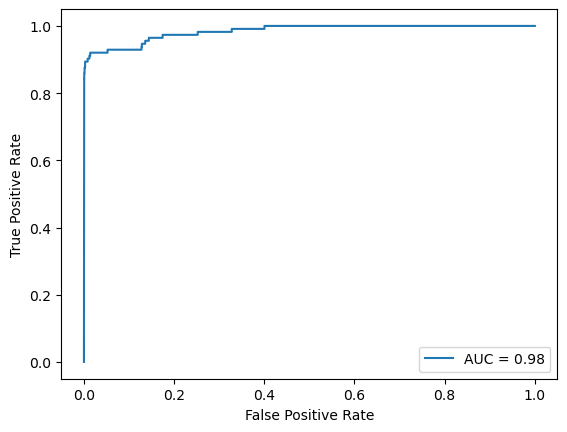

In [11]:
tfmodel = keras.models.load_model('tfMLP.h5')
scaler = joblib.load('tfScaler.sav')

probs = tfmodel.predict(scaler.transform(xtest))
fpr, tpr, thresholds = roc_curve(ytest, probs, pos_label=1)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

### Model Comparison
The best model of each family of models is selected for comparison (based on validation score).


Logistic Regression:

Precision = 86.8%, Recall = 65.9%, F1 = 74.2%

Tree Ensemble:   

Precision = 92.8%, Recall = 79.2%, F1 = 85.3%

MLP:

Precision = 84.2%, Recall = 81.0%, F1 = 82.6%

The best performing model is the Tree Ensemble model. As a result, this model is used for training and testing.
Note that even though precision of the MLP model is lower than Tree Ensemble model, its recall is higher. To choose between these two models one can look at the F1 score. Also, in case this does not satisfy the needs of the model, both of these models can be used alongside eachother to (possibly) cover each other's shortcomings.

# Final Model: Training and Testing

Training Accuracy: 1.0

Training Precision: 1.0

Training Recall: 1.0

Training F1 Score: 1.0


Testing Accuracy: 0.9996067526193084

Testing Precision: 0.9381443298969072

Testing Recall: 0.8053097345132744

Testing F1 Score: 0.8666666666666667


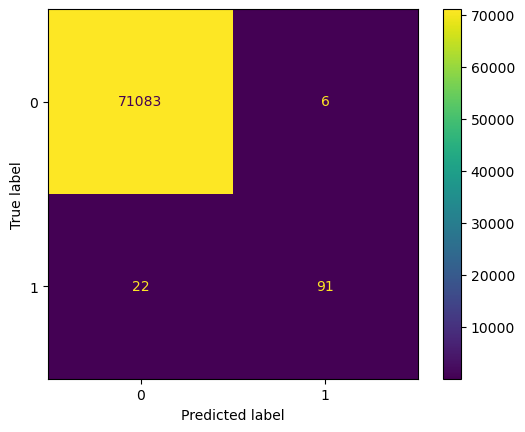

In [3]:
bagmodel = BaggingClassifier(n_jobs=-1, n_estimators=200)
bagmodel.fit(xtrain, ytrain)
joblib.dump(bagmodel, "treeEnsemble.sav")

preds = bagmodel.predict(xtrain)
print("Training Accuracy: {}".format(accuracy_score(ytrain, preds)))
print("Training Precision: {}".format(precision_score(ytrain, preds)))
print("Training Recall: {}".format(recall_score(ytrain, preds)))
print("Training F1 Score: {}".format(f1_score(ytrain, preds)))
print("=="*42)

preds = bagmodel.predict(xtest)
print("Testing Accuracy: {}".format(accuracy_score(ytest, preds)))
print("Testing Precision: {}".format(precision_score(ytest, preds)))
print("Testing Recall: {}".format(recall_score(ytest, preds)))
print("Testing F1 Score: {}".format(f1_score(ytest, preds)))

cofusionMatrix = confusion_matrix(ytest, preds)
display = ConfusionMatrixDisplay(confusion_matrix=cofusionMatrix, display_labels=bagmodel.classes_)
display.plot()

### Result analysis
At first sight it might be interpreted that the high training performance of the model is an indication of overfitting of the model. However, through making use of methods for battling overfitting in decision trees, both validation and training performances of the model decreased. This matter could be due to the highly skewed nature of the data: 99.87% of the data is in one class and 0.17% is in the other. The confusion matrix of the chosen model on the test set is shown above.

The performance of the best model is as follows:
- Precision: 93.8%
- Recall:    80.5%
- F1:        86.7%

These numbers provide the following interpretations:
- Of all the transactions the model marks as fraudulent, about 93.8% of them are correct.
- The model is capable of finding 80.5% of the fraudulent transactions in the data.

### Important Consideration
One must note that the model was built upon variables that were the results of Principle Component Analysis (PCA). This results in the input features being not interpretable. Furthermore, in order to deploy this model in real life scenarios, one must have access to the exact transformation function of the PCA that maps the original financial data to the ones we made use of.

### Conclusion
A machine learning model was selected and trained for the task of "Credit Card Fraud Detection". By having access to the PCA transformation function, this model is capable of providing results that help financial institutions find most of the fraudulent transactions among the plethora of legitimate transactions:
- This model can find 80.5% of the fraudulent transactions.
- 93.8% of all the fraudulent flags of the model are correct.